# Testing wavelets on siesmic dataset

In [311]:
# Import libraries
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
import pywt
from scipy import signal
from matplotlib import cm

# Load the dataset and convert to pandas

In [312]:
cat_directory = './data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)
cat

row = cat.iloc[6]
arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'],'%Y-%m-%dT%H:%M:%S.%f')
arrival_time
# Known events are identified in the catalog dataset, let's see if we can detect them
# If we want the value of relative time, we don't need to use datetime
arrival_time_rel = row['time_rel(sec)']
arrival_time_rel

# Let's also get the name of the file
#CSV
test_filename = row.filename
test_filename

data_directory = './data/lunar/training/data/S12_GradeA/'
csv_file = f'{data_directory}{test_filename}.csv'
data_cat = pd.read_csv(csv_file)
data_cat

# Read in time steps and velocities
csv_times = np.array(data_cat['time_rel(sec)'].tolist())
csv_data = np.array(data_cat['velocity(m/s)'].tolist())

#MSEDD
data_directory = './data/lunar/training/data/S12_GradeA/'
mseed_file = f'{data_directory}{test_filename}.mseed'
st = read(mseed_file)
st

# This is how you get the data and the time, which is in seconds
tr = st.traces[0].copy()
tr_times = tr.times()
tr_data = tr.data

st[0].stats

         network: XA
         station: S12
        location: 00
         channel: MHZ
       starttime: 1970-06-26T00:00:00.116000Z
         endtime: 1970-06-27T00:00:03.436755Z
   sampling_rate: 6.625
           delta: 0.1509433962264151
            npts: 572423
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 1136, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 4096, 'filesize': 4653056})

# Plot raw data timeseries and frequency response

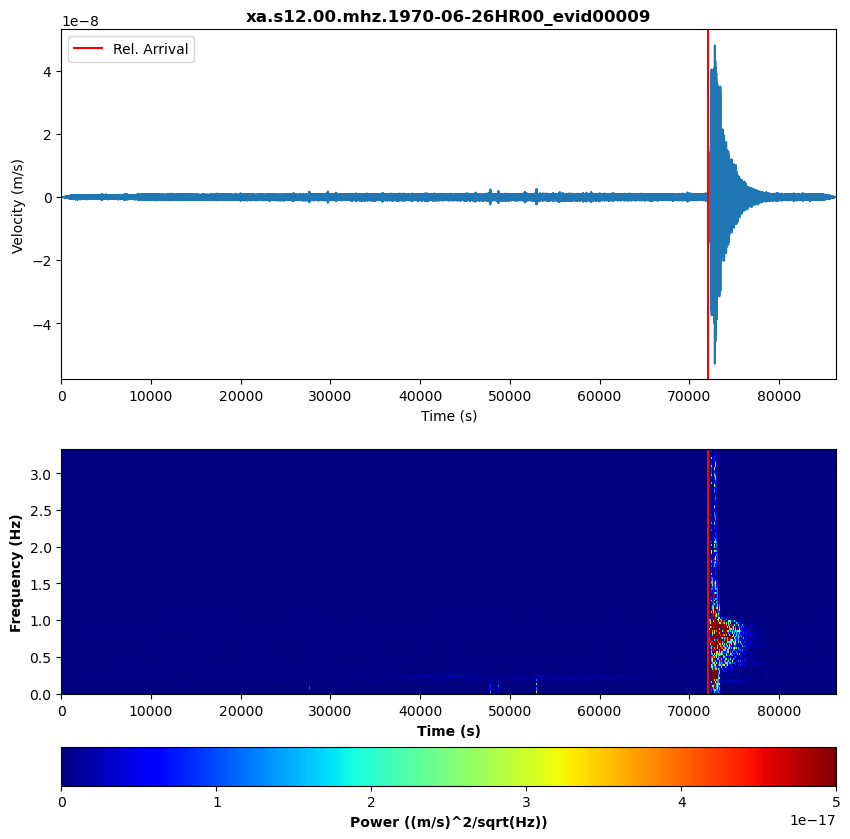

In [313]:
# Plot the time series and spectrogram
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 1, 1)
# Plot trace
ax.plot(csv_times,csv_data)

# Make the plot pretty
ax.set_xlim([min(csv_times),max(csv_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')

# Plot where the arrival time is
arrival_line = ax.axvline(x=arrival_time_rel, c='red', label='Rel. Arrival')
ax.legend(handles=[arrival_line])

# Going to create a separate trace for the filter data
st_raw = st.copy()
st_raw.filter('highpass', freq=0.01)
tr_filt = st_raw.traces[0].copy()
tr_times_raw = tr_filt.times()
tr_data_raw = tr_filt.data

fraw, traw, sxxraw = signal.spectrogram(tr_data_raw, tr_filt.stats.sampling_rate)

ax2 = plt.subplot(2, 1, 2)
vals = ax2.pcolormesh(traw, fraw, sxxraw, cmap=cm.jet, vmax=5e-17)
ax2.set_xlim([min(tr_times_filt),max(tr_times_filt)])
ax2.set_xlabel(f'Time (s)', fontweight='bold')
ax2.set_ylabel('Frequency (Hz)', fontweight='bold')
ax2.axvline(x=arrival_time_rel, c='red', label='Rel. Arrival')
cbar = plt.colorbar(vals, orientation='horizontal')
cbar.set_label('Power ((m/s)^2/sqrt(Hz))', fontweight='bold')

# Apply some filters to raw data

In [314]:
# Set the minimum frequency


# Going to create a separate trace for the filter data

st_filt = st.copy()
#st_filt.filter('highpass', freq=0.01)

minfreq = 0.1
maxfreq = 3.0
st_filt.filter('bandpass',freqmin=minfreq,freqmax=maxfreq)
tr_filt = st_filt.traces[0].copy()
tr_times_filt = tr_filt.times()
tr_data_filt = tr_filt.data

f, t, sxx = signal.spectrogram(tr_data_filt, tr_filt.stats.sampling_rate)

# Run STA/LTA algorithm

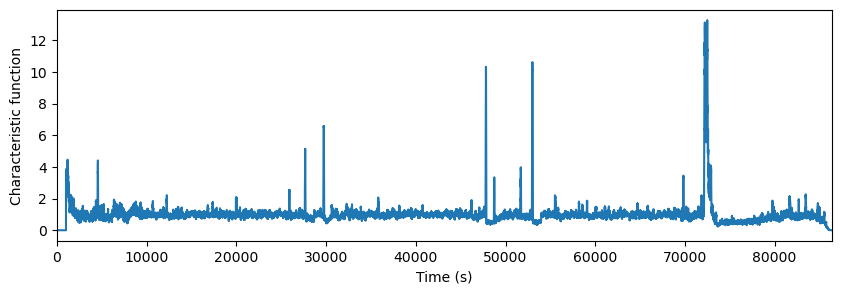

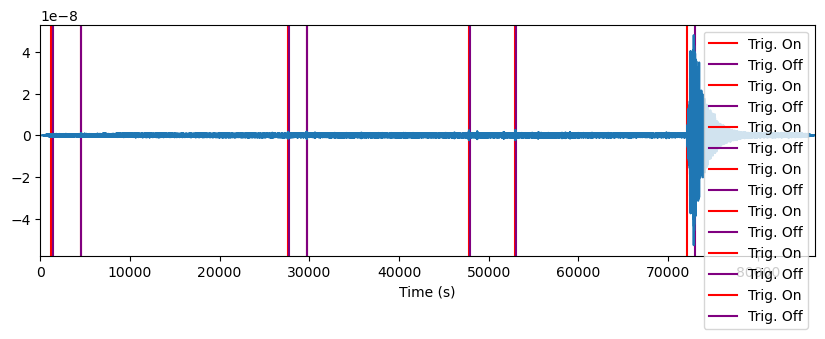

In [315]:
from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset

# Sampling frequency of our trace
df = tr.stats.sampling_rate

# How long should the short-term and long-term window be, in seconds?
sta_len = 50
lta_len = 1000

# Run Obspy's STA/LTA to obtain a characteristic function
# This function basically calculates the ratio of amplitude between the short-term 
# and long-term windows, moving consecutively in time across the data
cft = classic_sta_lta(tr_data, int(sta_len * df), int(lta_len * df))

# Plot characteristic function
fig1,ax1 = plt.subplots(1,1,figsize=(10, 3))
ax1.plot(tr_times,cft)
ax1.set_xlim([min(tr_times),max(tr_times)])
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Characteristic function')

# Play around with the on and off triggers, based on values in the characteristic function
thr_on = 4
thr_off = 1.5
on_off = np.array(trigger_onset(cft, thr_on, thr_off))
# The first column contains the indices where the trigger is turned "on". 
# The second column contains the indices where the trigger is turned "off".

# Plot on and off triggers
fig2,ax2 = plt.subplots(1,1,figsize=(10,3))
for i in np.arange(0,len(on_off)):
    triggers = on_off[i]
    ax2.axvline(x = tr_times[triggers[0]], color='red', label='Trig. On')
    ax2.axvline(x = tr_times[triggers[1]], color='purple', label='Trig. Off')

# Plot seismogram
ax2.plot(tr_times,tr_data)
ax2.set_xlim([min(tr_times),max(tr_times)])
ax2.set_xlabel('Time (s)')
ax2.legend()


# Continuous wavelet transformation (CWT) algorithm

In [317]:
import numpy as np
import matplotlib.pyplot as plt

import obspy
from obspy.imaging.cm import obspy_sequential
from obspy.signal.tf_misfit import cwt

tr = st.copy()
npts = st[0].stats.npts
data = tr.traces[0].data
dt = st[0].stats.delta
t = np.linspace(0, dt * npts, npts)
f_min = 0.1
f_max = 3

scalogram = cwt(data, dt, 8, f_min, f_max)

x, y = np.meshgrid(
    t,
    np.logspace(np.log10(f_min), np.log10(f_max), scalogram.shape[0]))


KeyboardInterrupt: 

# Plot CWT versus spectrogram

Text(0, 0.5, 'Frequency [Hz]')

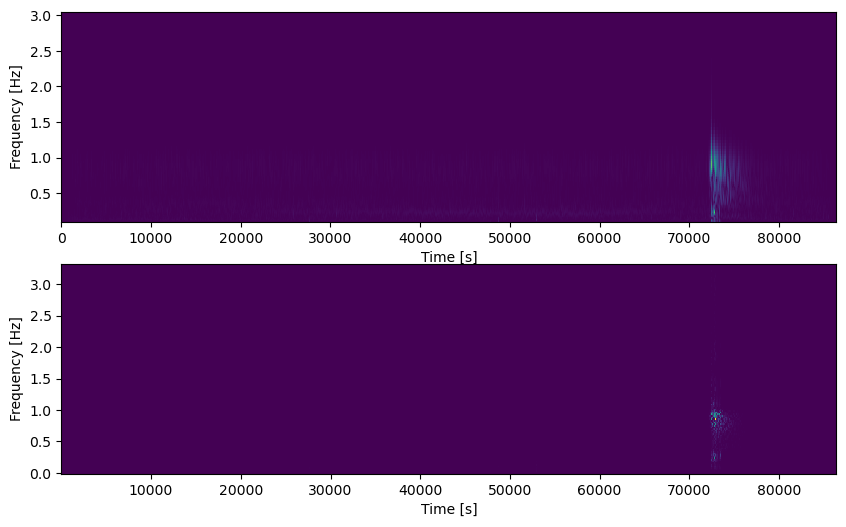

In [102]:
fig = plt.figure(figsize=(10,6))
ax = plt.subplot(2, 1, 1)
ax.pcolormesh(x, y, np.abs(scalogram), cmap=obspy_sequential)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Frequency [Hz]")
#ax.set_yscale('log')
#ax.set_ylim(f_min, f_max)

ax2 = plt.subplot(2, 1, 2)
vals = ax2.pcolormesh(traw, fraw, sxxraw, cmap=obspy_sequential)
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Frequency [Hz]")
#ax2.set_yscale('log')
#cbar = plt.colorbar(vals, orientation='horizontal')
#cbar.set_label('Power ((m/s)^2/sqrt(Hz))', fontweight='bold')

# Evaluate spectral density on wavelet & spectrogram

ValueError: x and y must have same first dimension, but have shapes (1278,) and (129, 1278)

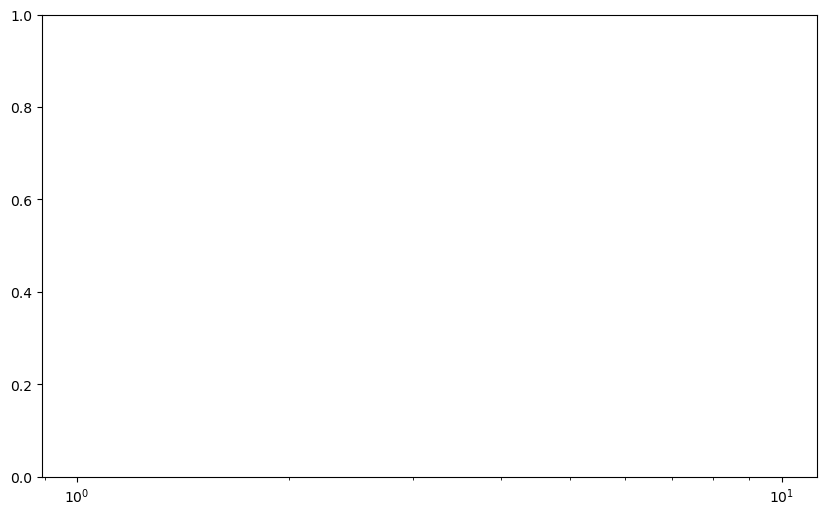

In [146]:
#SpectralDensity = signal.welch(scalogram, fs= st[0].stats.sampling_rate, return_onesided=False)

freq, dens = signal.welch(sxxraw, fs= st[0].stats.sampling_rate, scaling='spectrum', nperseg=sxxraw.shape[1])

fig = plt.figure(figsize=(10,6))
ax = plt.subplot(1, 1, 1)
ax.semilogx(freq, dens)

# Find peaks on filtered data

In [285]:
tr = st.copy()
npts = st[0].stats.npts
tr_times = tr.traces[0].times()
data = tr.traces[0].data
dt = st[0].stats.delta

maxpeak = max(abs(data))
peakwd= 2000/dt

#Idx = signal.find_peaks_cwt(data, width, wavelet=signal.morlet2)
#width, distance
#threshold : variation between two points
#prominence : height of hills and valleys
#height = [0.25*maxpeak, maxpeak]

Idx = signal.find_peaks(abs(data), threshold=[0.25*maxpeak, maxpeak], prominence=[0.1*maxpeak, maxpeak], distance=peakwd)


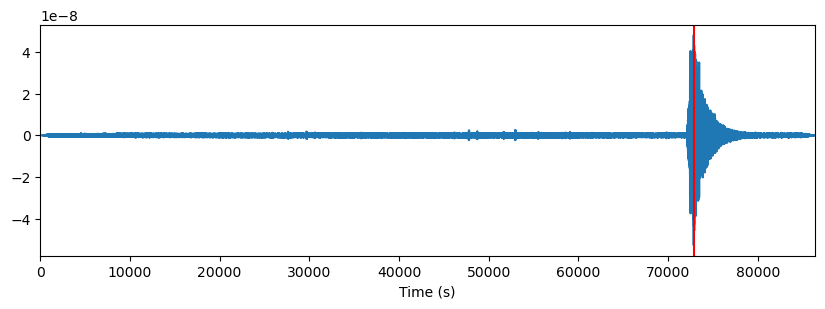

In [310]:
# Plot on and off triggers
fig,ax = plt.subplots(1,1,figsize=(10,3))
# Plot seismogram
ax.plot(tr_times, data)
ax.set_xlim([min(tr_times), max(tr_times)])
ax.set_xlabel('Time (s)')

if len(Idx[0]) > 0:
    lines = tr_times[Idx[0][:]]
    for i in np.arange(0,len(Idx[0])):
        ax.axvline(x = lines[i], color='red')
    

# Cross-correlation

AttributeError: 'Stream' object has no attribute 'times'

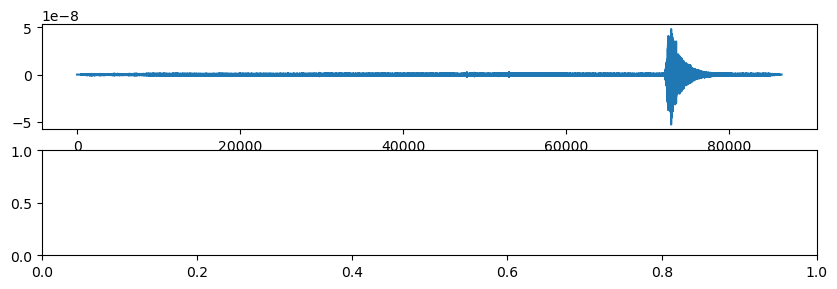

In [309]:
from obspy import read, UTCDateTime as UTC
from obspy.signal.cross_correlation import correlation_detector
templatefile = mseed_file
template = read(templatefile)

template_trace = template.traces[0].copy()
template_times = template_trace.times()
template_data = template_trace.data

pick = UTC('1970-06-26T19:57:12.34')
template.trim(pick, pick+5000)

height = 0.3 # threshold 
distance = 100 # time in seconds between detection

#data_directory = './data/lunar/training/data/S12_GradeA/'
#mseed_file2 = f'{data_directory}{test_filename}.mseed'

mseed_fileAnalyze = templatefile
stream = read(mseed_fileAnalyze)

#detections, sims = correlation_detector(stream, template, height, distance, plot=stream)
detections, sims = correlation_detector(stream, template, height, distance)

fig,ax = plt.subplots(2,1,figsize=(10,3))
#Template data
ax = plt.subplot(2, 1, 1)
ax.plot(template_times, template_data)
ax.set_xlim([min(template.times), max(template.times)])
ax.set_xlabel('Time (s)')

detect_trace = stream.traces[0].copy()
detect_time = detect_trace.time()
detect_data = detect_trace.data

ax2 = plt.subplot(2, 1, 2)
ax2.plot(detect_time, detect_data)
ax2.set_xlim([min(detect_time), max(detect_time)])
ax2.set_xlabel('Time (s)')

BeginTime = detect_trace.stats['starttime'].timestamp
for detection in detections:
        reltime = detection['time'].timestamp - BeginTime
        ax2.axvline(x = reltime, color='red')